In [1]:
import arviz as az
import networkx as nx
import numpy as np
import pandas as pd
from pywhy_graphs.viz import draw
import pymc as pm
from scipy import stats
from statsmodels.genmod.families.links import Logit
import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
warnings.filterwarnings('ignore')

1\. Conduct a prior predictive simulation for the Reed frog model. By this I mean to simulate the prior distribution of tank survival probabilities αj. Start by using this prior:

αj ∼Normal(α ̄,σ)
α ̄ ∼ Normal(0, 1)
σ ∼ Exponential(1)

Be sure to transform the αj values to the probability scale for plotting and summary. How does increasing the width of the prior on σ change the prior distribution of αj? You might try Exponential(10) and Exponential(0.1) for example.

In [3]:
# sigma=1.0
with pm.Model() as m1_1:
    sigma = pm.Exponential("sigma", 1.)
    a_bar = pm.Normal("a_bar", 0., 1.)
    aT = pm.Normal("aT", a_bar, sigma)
    t1_1 = pm.sample(1000, tune=1000)

# sigma=0.1
with pm.Model() as m1_2:
    sigma = pm.Exponential("sigma", 0.1)
    a_bar = pm.Normal("a_bar", 0., 1.)
    aT = pm.Normal("aT", a_bar, sigma)
    t1_2 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_bar, aT]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_bar, aT]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [4]:
logit = Logit()
aT_1_samples = az.extract(t1_1, num_samples=1000).aT
p1_samples = logit.inverse(aT_1_samples)

In [5]:
aT_2_samples = az.extract(t1_2, num_samples=1000).aT
p2_samples = logit.inverse(aT_2_samples)

array([[<Axes: title={'center': 'x'}>]], dtype=object)

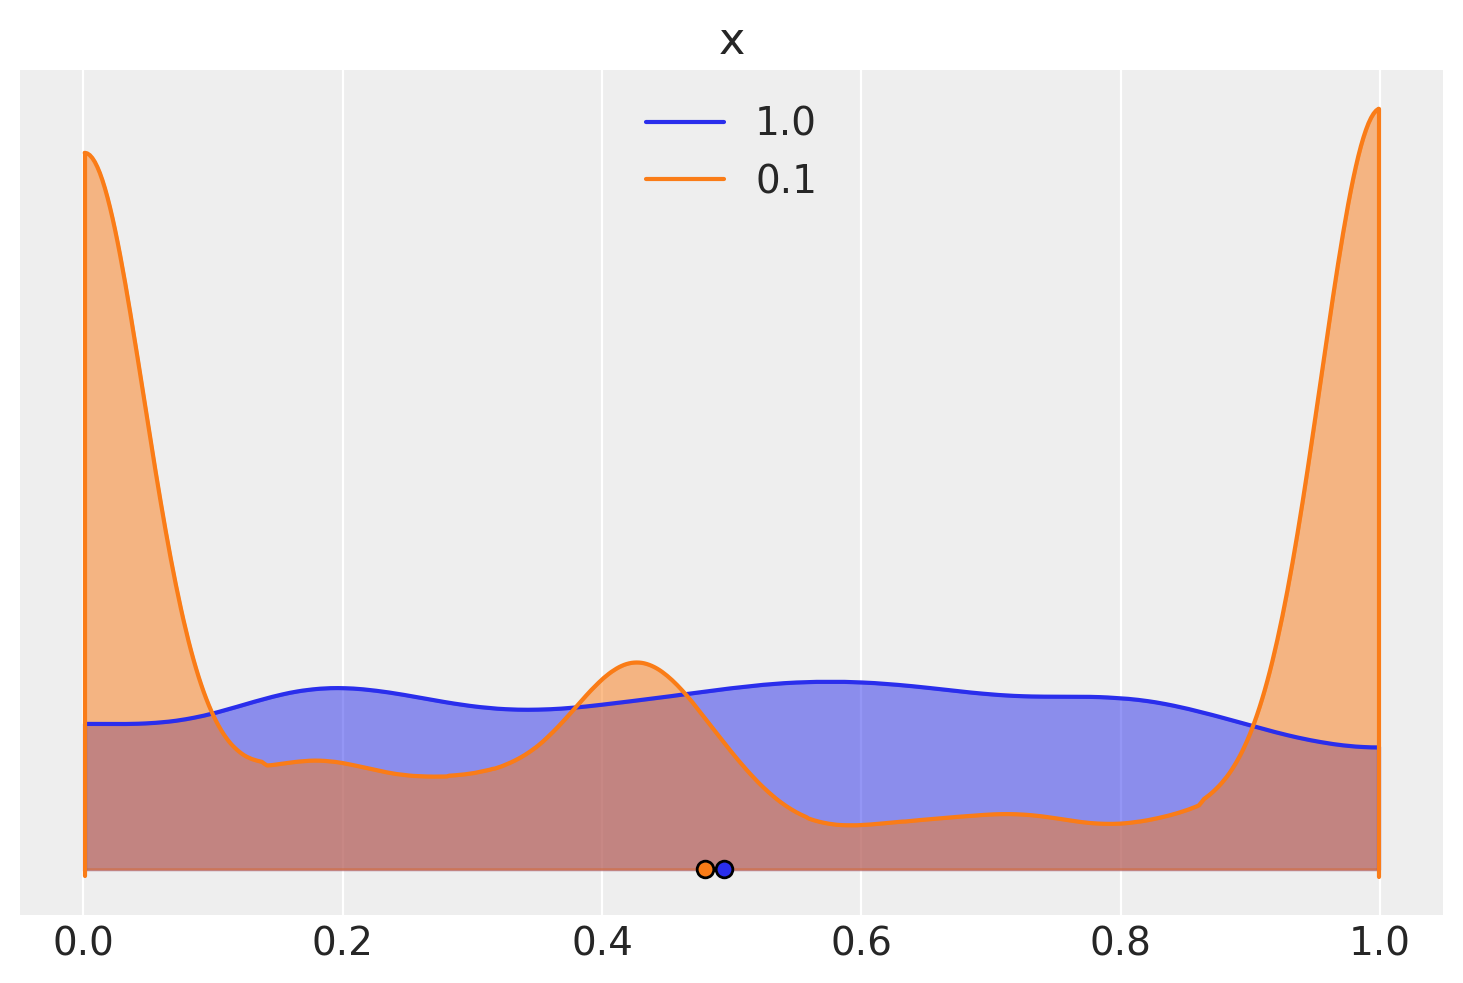

In [6]:
az.plot_density([p1_samples, p2_samples], data_labels=["1.0", "0.1"], shade=0.5, hdi_prob=1.)

2\. Revisit the Reedfrog survival data, data(reedfrogs). Start with the varying effects model from the book and lecture. Then modify it to estimate the causal effects of the treatment variables pred and size, including how size might modify the effect of predation. An easy approach is to estimate an effect for each combination of pred and size. Justify your model with a DAG of this experiment.

In [7]:
d = pd.read_csv("../../Data/reedfrogs.csv", sep=",", header=0)
d.head(10)

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9
5,10,no,small,9,0.9
6,10,no,small,10,1.0
7,10,no,small,9,0.9
8,10,pred,big,4,0.4
9,10,pred,big,9,0.9


In [8]:
d.dtypes

density       int64
pred         object
size         object
surv          int64
propsurv    float64
dtype: object

In [9]:
d2 = d.copy()

In [10]:
d2.pred = d2.pred.astype("category").cat.codes
d2["size"] = d2["size"].astype("category").cat.codes
d2.tank = [i for i in range(1, 49)]
d2

,density,pred,size,surv,propsurv
0,10,0,0,9,0.900000
1,10,0,0,10,1.000000
2,10,0,0,7,0.700000
3,10,0,0,10,1.000000
4,10,0,1,9,0.900000
5,10,0,1,9,0.900000
6,10,0,1,10,1.000000
7,10,0,1,9,0.900000
8,10,1,0,4,0.400000
9,10,1,0,9,0.900000


In [11]:
with pm.Model() as m2:
    T = [x - 1 for x in d2.tank]
    S = d2.surv
    P = d2.pred
    G = d2["size"]
    D = d2.density

    num_Ps = max(P) + 1
    num_Gs = max(G) + 1
    num_Ts = max(T) + 1

    sigma = pm.Exponential("sigma", 1)
    a = pm.Normal("a", 0., sigma, shape=num_Ts)
    b = pm.Normal("b", 0., 1, shape=(num_Ps, num_Gs))
    p = pm.math.invlogit(a[T] + b[P, G])
    S = pm.Binomial("S", n=D, p=p, observed=S)
    t2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

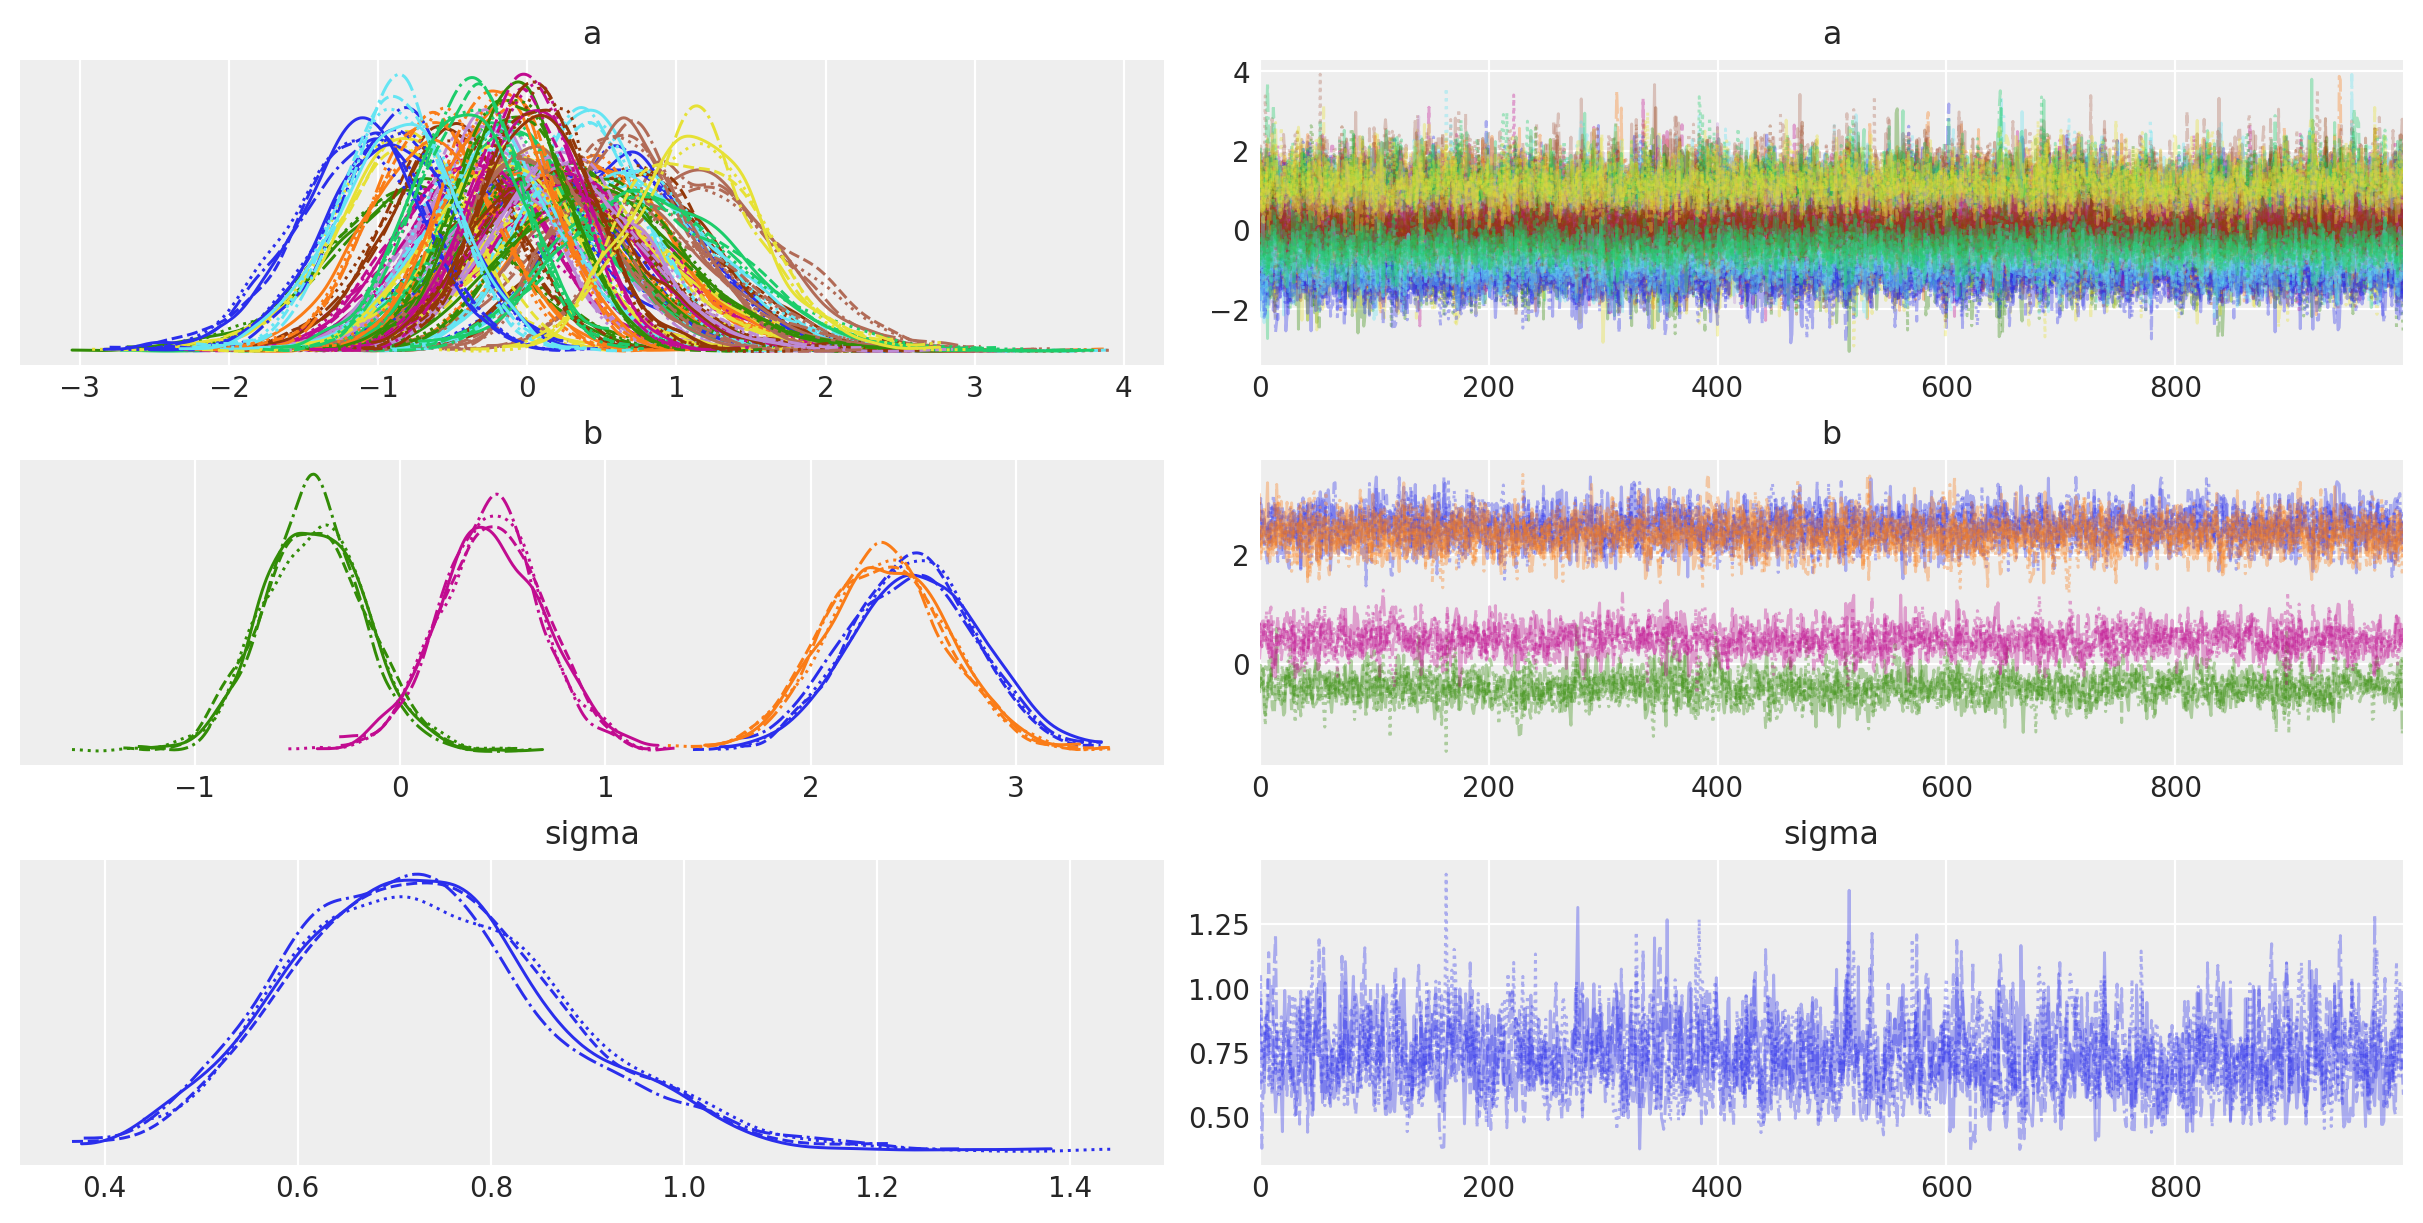

In [12]:
az.plot_trace(t2)

In [13]:
az.summary(t2, round_to=2, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],-0.04,0.61,-1.06,0.92
a[1],0.36,0.67,-0.74,1.37
a[2],-0.73,0.59,-1.60,0.28
a[3],0.36,0.65,-0.66,1.39
a[4],-0.00,0.61,-0.95,0.96
a[5],0.00,0.63,-0.93,1.03
a[6],0.40,0.66,-0.75,1.37
a[7],-0.01,0.61,-0.91,1.01
a[8],-0.02,0.53,-0.83,0.87
a[9],1.19,0.55,0.36,2.08


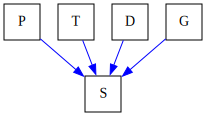

In [14]:
G = nx.DiGraph([("P", "S"), ("T", "S"), ("D", "S"), ("G", "S")])
draw(G, node_shapes="o")

3\. Now estimate the causal effect of density on survival. Consider whether pred modifies the effect of density. There are several good ways to include density in your Binomial GLM. You could treat it as a continuous regression variable (possi- bly standardized). Or you could convert it to an ordered category (with three lev- els). Compare the σ (tank standard deviation) posterior distribution to σ from your model in Problem 2. How are they different? Why?

In [15]:
with pm.Model() as m3:
    T = [x - 1 for x in d2.tank]
    S = d2.surv
    P = d2.pred
    G = d2["size"]
    Do = stats.zscore(d2.density)

    num_Ps = max(P) + 1
    num_Gs = max(G) + 1
    num_Ts = max(T) + 1

    bD = pm.Normal("bD", 0, 0.5, shape=num_Ps)
    sigma = pm.Exponential("sigma", 1)
    a = pm.Normal("a", 0., sigma, shape=num_Ts)
    b = pm.Normal("b", 0., 1, shape=(num_Ps, num_Gs))
    p = pm.math.invlogit(a[T] + b[P, G] + bD[P]*Do)
    S = pm.Binomial("S", n=D, p=p, observed=S)
    t3 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bD, sigma, a, b]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [ ]:
az.plot_trace(t2)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

In [ ]:
az.summary(t3, round_to=2, kind="stats")

In [18]:
dict(enumerate(d["size"].astype("category").cat.categories ))

{0: 'big', 1: 'small'}

In [19]:
dict(enumerate(d.pred.astype("category").cat.categories))

{0: 'no', 1: 'pred'}